<a href="https://colab.research.google.com/github/BeletAntoine/Machine_Learning/blob/main/Projet1/Projet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>  Chest X-rays Detection

In [2]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import keras
import glob
import os

In [3]:
os.environ["KERAS_BACKEND"] = "tensorflow"

### 1) Download kaggle files

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:45<00:00, 23.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


We get the folder structure with the code:
```
tree -L 3 path
```

Which gives the following structure:
```
Path
└── chest_xray
    ├── chest_xray
    │   ├── test
    │   ├── train
    │   └── val
    ├── __MACOSX
    │   └── chest_xray
    ├── test
    │   ├── NORMAL
    │   └── PNEUMONIA
    ├── train
    │   ├── NORMAL
    │   └── PNEUMONIA
    └── val
        ├── NORMAL
        └── PNEUMONIA
```
Files in the NORMAL and PNEUMONIA folders are all of ".jpg" extension.

### 2) Verify the data

Using the kaggle datasets, you can usually assume the dataset will be of quality, however it's still important to know your data and verify what it looks like.

Let's check that !

In [5]:
# Get the paths for the train, test and val folders
chest_xray_path = path + "/chest_xray"
test_path = chest_xray_path + "/test"
train_path = chest_xray_path + "/train"
val_path = chest_xray_path + "/val"

In [6]:
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib

# Get the Normal and Pneumonia path from a  parent folder
def normal_n_pneumonia_paths(parent_folder_path):
    return (parent_folder_path + "/NORMAL"), ( parent_folder_path + "/PNEUMONIA")

# Return random images paths from the folder given
def select_random_images_from_folder(path_folder, number_images):

    list_images_path = glob.glob(path_folder + "/**/*.jpeg", recursive=True)

    print(f'Number of images in folder : {len(list_images_path)}')

    array_numbers_len_list = np.arange(0, len(list_images_path))

    # Select number_images numbers from the list
    list_random_numbers = np.random.choice(array_numbers_len_list, number_images)

    print(f'Indices selected : {list_random_numbers}')

    return [list_images_path[i] for i in list_random_numbers]

# Print images from their path
def print_images_from_path(array_dim1_images_path):
    num_images = len(array_dim1_images_path)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # One row, multiple columns

    if num_images == 1:  # Handle single image case
        axes = [axes]

    for ax, image_path in zip(axes, array_dim1_images_path):
        img = matplotlib.image.imread(image_path)  # Read image correctly
        ax.imshow(img, cmap="gray")
        ax.axis("off")  # Hide axes

    plt.show()

# Select random images from the folder and display them
def select_n_display_images_from_folder(path_folder, number_images):
    list_random_images_paths = select_random_images_from_folder(path_folder, number_images)
    print_images_from_path(list_random_images_paths)
    return list_random_images_paths


/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL
Number of images in folder : 1341
Indices selected : [ 848  586  683 1249  566]


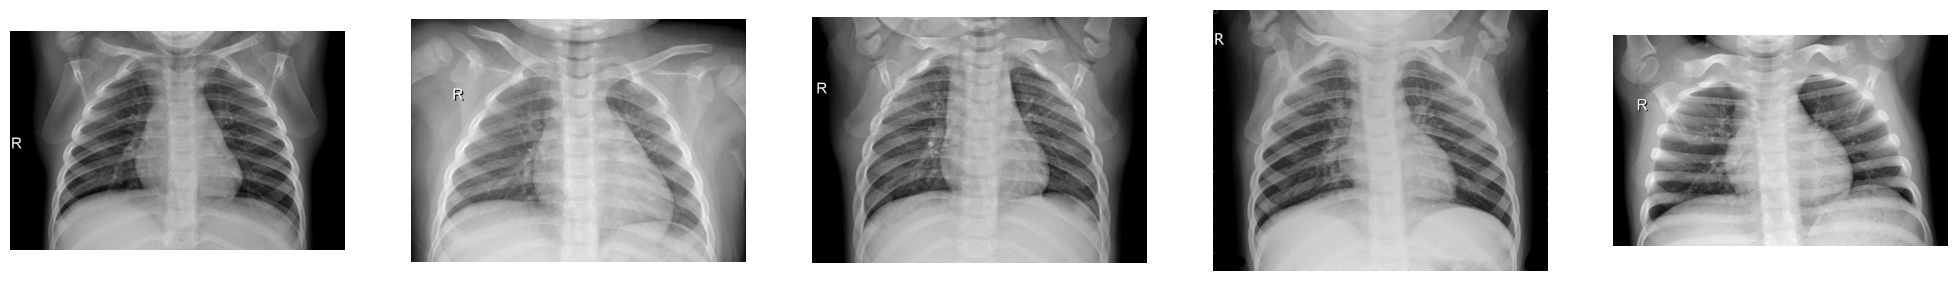

['/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0448-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0224-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0746-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-1086-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-1055-0001.jpeg']
Number of images in folder : 3875
Indices selected : [1270 2708  606 2187  776]


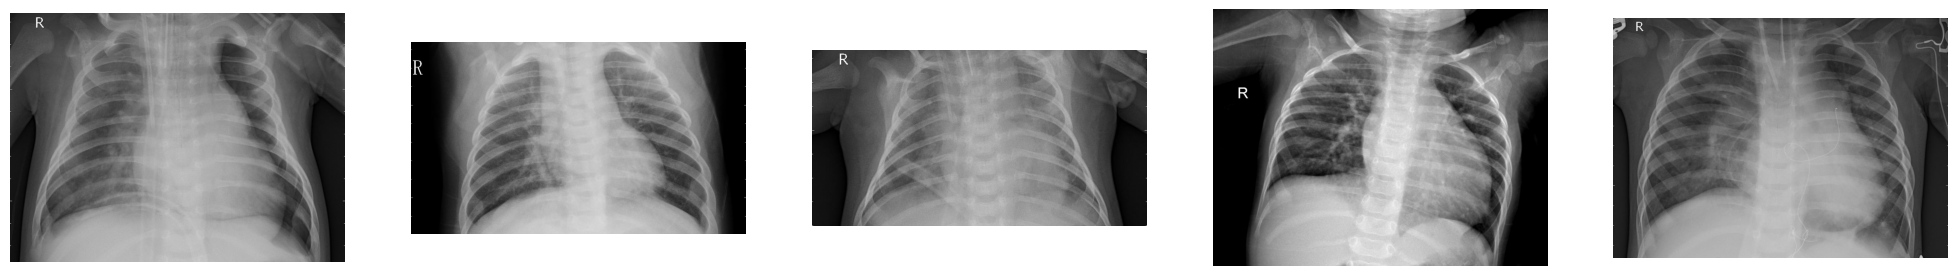

['/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person564_bacteria_2343.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1046_virus_1742.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person20_bacteria_70.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1098_bacteria_3039.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person922_bacteria_2847.jpeg']


In [7]:
num_images_to_display = 5

train_normal_path, train_pneumonia_path = normal_n_pneumonia_paths(train_path)
print(train_normal_path)

list_random_images_paths_normal = select_n_display_images_from_folder(train_normal_path, num_images_to_display)
print(list_random_images_paths_normal)

list_random_images_paths_pneumonia = select_n_display_images_from_folder(train_pneumonia_path, num_images_to_display)
print(list_random_images_paths_pneumonia)


### 3) Standardise the data

The data needs to have the same shape, rescaling pixel value to [0,1]

#### Reshape

In [8]:
from PIL import Image
from collections import defaultdict

# Verify the shapes existing

def count_num_images_shapes(folder_path):
    # Dictionary to count occurrences of each unique shape
    shape_counts = defaultdict(int)

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg")):
            file_path = os.path.join(folder_path, filename)
            with Image.open(file_path) as img:
                shape = img.size  # (width, height)
                shape_counts[shape] += 1  # Count occurrences of each shape

    # Print unique shapes and their counts
    #for shape, count in shape_counts.items():
    #    print(f"Shape {shape}: {count} images")
    nb_shapes = 10
    if len(shape_counts.items()) > nb_shapes:
      print(f"There are more than {nb_shapes} different shapes in this dictionary.")

    return shape_counts

In [9]:
dictionary_shapes = count_num_images_shapes(train_normal_path)

There are more than 10 different shapes in this dictionary.


All the shapes are different, let's try ro find a shape that would work on all images, starting with the minimum shape (both width and height).

In [10]:
list_shapes = list(dictionary_shapes.keys())

# Get the min width and heigth
min_width, min_height = list(map(min, zip(*list_shapes)))
print(f"Min width: {min_width} \nMin height: {min_height}")

Min width: 912 
Min height: 672


We like powers of 2 for shapes as it works very well with maximisation of physical space, pooling steps, etc.

Let's reshape our images to (224, 224) wich is the value most pre-trained models have been trained on. Also the lower values for the width and height are to avoid using padding on images.

All images seem to have been resized without any issues, let's start loading the whole dataset for training.

In [11]:
import os

def count_files_and_classes(folder_path):

    # Get the list of subfolders (classes)
    class_names = sorted(os.listdir(folder_path))
    num_classes = len(class_names)

    # Count the number of files in each class
    class_counts = {}
    total_files = 0

    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):  # Ensure it's a directory
            num_files = len(os.listdir(class_folder))
            class_counts[class_name] = num_files
            total_files += num_files

    return class_counts, total_files, num_classes

In [12]:
# Check the training dataset
class_counts, total_files, num_classes = count_files_and_classes(train_path)

# Print the results
print("Training class counts:", class_counts)
print("Training total number of files:", total_files)
print("Training total number of classes:", num_classes)

Training class counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Training total number of files: 5216
Training total number of classes: 2


In [13]:
# Check the Validation dataset
class_counts, total_files, num_classes = count_files_and_classes(val_path)

# Print the results
print("Validation class counts:", class_counts)
print("Validation total number of files:", total_files)
print("Validation total number of classes:", num_classes)

Validation class counts: {'NORMAL': 8, 'PNEUMONIA': 8}
Validation total number of files: 16
Validation total number of classes: 2


In [14]:
# Check the Validation dataset
class_counts, total_files, num_classes = count_files_and_classes(test_path)

# Print the results
print("Test class counts:", class_counts)
print("Test total number of files:", total_files)
print("Test total number of classes:", num_classes)

Test class counts: {'NORMAL': 234, 'PNEUMONIA': 390}
Test total number of files: 624
Test total number of classes: 2


Sometimes even having a great database is not enough. I will use data augmentation to diversify the datasets.

In [15]:
def directory_path_to_keras_dataset(directory_path, target_size, batch_size=None):


    # create the dataset with keras directly from the directory
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
                  directory_path,
                  image_size=target_size,
                  label_mode="binary",
                  color_mode="rgb",
                  batch_size=batch_size,
                  shuffle=True,
                  verbose=True
                  )

    # Prefetch for performance
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    print(f"Number of batches = {dataset.cardinality().numpy()}")

    return dataset

Load the datasets

In [16]:
# Define image size
width = 224
height = 224
target_size = (width, height)  # Desired shape
batch_size = 64

In [17]:
import tensorflow as tf

# Load test dataset
test_dataset = directory_path_to_keras_dataset(test_path, target_size, batch_size)

Found 624 files belonging to 2 classes.
Number of batches = 10


In [18]:
for data, label in test_dataset.take(1):
  print(label)

tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]], shape=(64, 1), dtype=float32)


Adding more data to the validation dataset, I have the long issue of having a very high validation loss.

In [19]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob

# Get file paths and labels
train_files = glob.glob(train_path + "/**/*.jpeg", recursive=True)
train_labels = [0 if "NORMAL" in path else 1 for path in train_files]

# Split into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# Function to load and preprocess images
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]

    # Add extra dimension to the label (shape [1] -> [1, 1]) to get the same shape as the test dataset
    label = tf.expand_dims(label, axis=-1)
    return image, label

def dataset_from_train_test_split(list_files, list_labels, batch_size):
  print(f"Number of elements in the set : {len(list_files)}")
  dataset = tf.data.Dataset.from_tensor_slices((list_files, list_labels))
  dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.shuffle(buffer_size=len(list_files))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

  return dataset

# Create training dataset
train_dataset = dataset_from_train_test_split(train_files, train_labels, batch_size)

# Create validation dataset
val_dataset = dataset_from_train_test_split(val_files, val_labels, batch_size)

Number of elements in the set : 4172
Number of elements in the set : 1044


In [20]:
# Inspect the datasets
for images, labels in train_dataset.take(1):
    print("Training batch shape:", images.shape)
    print("Training labels:", labels)

for images, labels in val_dataset.take(1):
    print("Validation batch shape:", images.shape)
    print("Validation labels:", labels)

Training batch shape: (64, 224, 224, 3)
Training labels: tf.Tensor(
[[1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(64, 1), dtype=int32)
Validation batch shape: (64, 224, 224, 3)
Validation labels: tf.Tensor(
[[1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]], shape=(64, 1), dtype=int32)


We have to ensure the data are of the same format

In [21]:
# For your first approach (custom dataset)
train_labels = tf.cast(train_labels, tf.float32)  # Ensure float32
val_labels = tf.cast(val_labels, tf.float32)  # Ensure float32

def normalize_img(image, label):
    return image / 255.0, label  # Normalize to [0, 1]

test_dataset = test_dataset.map(normalize_img)  # Apply normalization

In [22]:
# Inspect the modified datasets
for images, labels in train_dataset.take(1):
    print("Training batch shape:", images.shape)
    print("Training labels:", labels)

for images, labels in val_dataset.take(1):
    print("Validation batch shape:", images.shape)
    print("Validation labels:", labels)

Training batch shape: (64, 224, 224, 3)
Training labels: tf.Tensor(
[[0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]], shape=(64, 1), dtype=int32)
Validation batch shape: (64, 224, 224, 3)
Validation labels: tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]], shape=(64, 1), dtype=int32)


We have to balance the classes as well

In [23]:
from sklearn.utils import class_weight as sklearn_class_weight  # Rename the imported module

def balance_weight_classes(dataset):
    # Extract labels from the dataset
    labels = np.concatenate([y.numpy() for x, y in dataset], axis=0)  # Convert to NumPy array
    labels = labels.flatten()  # Ensure labels are 1D

    # Compute class weights
    class_weight = sklearn_class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(labels),
        y=labels
    )

    # Convert to a dictionary
    class_weight = dict(enumerate(class_weight))

    return class_weight

In [24]:
# Balancing the classes
train_classes_weights = balance_weight_classes(train_dataset)
print(train_classes_weights)

{0: np.float64(1.9440820130475303), 1: np.float64(0.6731203614069055)}


### 4) Creation of model

In [25]:
input_shape = (width, height, 3)  # Desired shape for rgb image
nb_classes = 1

Issues arose with the use of pre-trained models, surely due to overfitting, the val_loss function tweaking, even with 20% of the train dataset used for the validation.

Here is a small CNN used not to overkill the problem and overfit in case the pre-trained doesn't work.

In [26]:
import tensorflow as tf
from keras import layers, models

def create_cnn_model(input_shape=input_shape):
    """
    Creates a 16-layer CNN model for binary classification of RGB images.

    Args:
        input_shape (tuple): Shape of the input images (height, width, channels).

    Returns:
        model (tf.keras.Model): Compiled CNN model.
    """
    model = models.Sequential()

    model.add(layers.Input(shape=input_shape))

    # Layer 1: Convolutional + ReLU + MaxPooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Layer 2: Convolutional + ReLU + MaxPooling
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Layer 3: Convolutional + ReLU + MaxPooling
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Layer 4: Convolutional + ReLU + MaxPooling
    model.add(layers.Conv2D(128, (3, 3), activation='relu', name="last_conv"))
    model.add(layers.MaxPooling2D((2, 2)))

    # Layer 5: Flatten
    model.add(layers.Flatten())

    # Layer 6: Dense + ReLU
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    # Layer 7: Dense + ReLU
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    # Layer 8: Output Layer (Dense + Sigmoid for binary classification)
    model.add(layers.Dense(1, activation='sigmoid', name="predictions"))
    return model

image_classifier = create_cnn_model(input_shape)

# Print the model summary
image_classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last_conv (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,992,705 (19.05 MB)

 Trainable params: 4,992,705 (19.05 MB)

 Non-trainable params: 0 (0.00 B)

## Manual Model

### Training

In [27]:
# Variables used in the training section
epochs = 25

In [28]:
image_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy (name="acc"),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall"),
             keras.metrics.AUC(name="auc")]
)

best_model_path = "best_model.keras"

image_classifier_callbacks = [
    keras.callbacks.ModelCheckpoint(best_model_path, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]

In [29]:
history_image_classifier = image_classifier.fit(
        train_dataset,
        epochs=epochs,
        callbacks=image_classifier_callbacks,
        validation_data=val_dataset,
        class_weight=train_classes_weights,
        verbose=1
    )

Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 187ms/step - acc: 0.5029 - auc: 0.6327 - loss: 0.6713 - precision: 0.8177 - recall: 0.4011 - val_acc: 0.8956 - val_auc: 0.9615 - val_loss: 0.2678 - val_precision: 0.9691 - val_recall: 0.8879
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - acc: 0.9038 - auc: 0.9645 - loss: 0.2461 - precision: 0.9642 - recall: 0.9027 - val_acc: 0.9349 - val_auc: 0.9862 - val_loss: 0.1799 - val_precision: 0.9930 - val_recall: 0.9188
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - acc: 0.9292 - auc: 0.9810 - loss: 0.1757 - precision: 0.9767 - recall: 0.9257 - val_acc: 0.9713 - val_auc: 0.9913 - val_loss: 0.0857 - val_precision: 0.9807 - val_recall: 0.9807
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - acc: 0.9561 - auc: 0.9889 - loss: 0.1311 - precision: 0.9855 - recall: 0.9556 - val_acc: 0.9808 - val_auc: 0.9916 - val_loss: 0.0777 - val_precision: 0.9809 - val_recall: 0.9936
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - acc: 0.9663 - auc

In [30]:
# Access history data
print(history_image_classifier.history.keys())  # Shows available metrics like loss, accuracy, etc.
print(history_image_classifier.history['loss'])  # Prints loss value per epoch
print(history_image_classifier.history['acc'])  # Prints accuracy value per epoch
print(history_image_classifier.history['precision'])  # Prints Precision value per epoch
print(history_image_classifier.history['recall'])  # Prints Recall value per epoch
print(history_image_classifier.history['auc'])  # Prints AUC value per epoch

dict_keys(['acc', 'auc', 'loss', 'precision', 'recall', 'val_acc', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])
[0.5519205927848816, 0.22580629587173462, 0.15209200978279114, 0.12061028927564621, 0.08921080082654953, 0.06739982962608337, 0.07403595000505447, 0.05393172428011894, 0.04394005611538887, 0.048158641904592514, 0.05671125277876854]
[0.6488494873046875, 0.9134707450866699, 0.9419942498207092, 0.9554170370101929, 0.9686002135276794, 0.9748322367668152, 0.9717162251472473, 0.9779482483863831, 0.9839405417442322, 0.9825024008750916, 0.9774688482284546]
[0.9064676761627197, 0.9720689654350281, 0.98211270570755, 0.9876129627227783, 0.991065502166748, 0.9943857192993164, 0.9927272796630859, 0.9947351217269897, 0.9957488775253296, 0.9950916171073914, 0.9940809011459351]
[0.5879315733909607, 0.9096482992172241, 0.9390125870704651, 0.9519199728965759, 0.9664407968521118, 0.9716037511825562, 0.969022274017334, 0.9754759669303894, 0.982574999332428, 0.9812842607498169, 0.975475

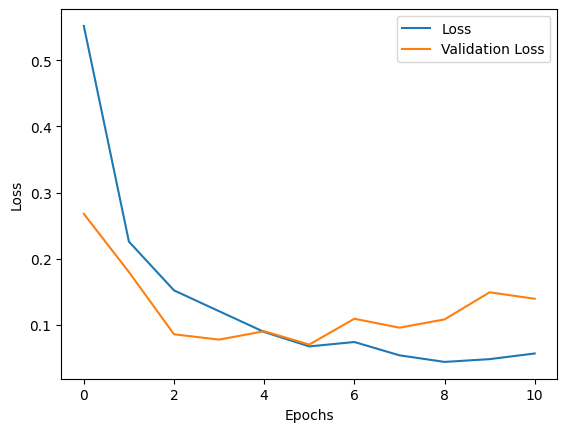

In [31]:
# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history_image_classifier.history['loss'], label='Loss')
plt.plot(history_image_classifier.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

In [32]:
score_model = image_classifier.evaluate(test_dataset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - acc: 0.7929 - auc: 0.9024 - loss: 0.9447 - precision: 0.7466 - recall: 0.9909


In [33]:
# Print the evaluation results
print(f"Test Loss: {score_model[0]}")
print(f"Test Accuracy: {score_model[1]}")
print(f"Test Precision: {score_model[2]}")
print(f"Test Recall: {score_model[2]}")

f1_score_model = 2 * (score_model[2] * score_model[3]) / (score_model[2] + score_model[3])
print(f"Test F1 Score: {f1_score_model}")

Test Loss: 0.9315394759178162
Test Accuracy: 0.8060897588729858
Test Precision: 0.7695390582084656
Test Recall: 0.7695390582084656
Test F1 Score: 0.8638920012816083


### Application

In [34]:
import cv2
from scipy.ndimage import zoom

In [35]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Predict on the test dataset
predictions = image_classifier.predict(test_dataset)

# Convert predictions to class labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)  # Threshold = 0.5

# Extract true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
auc = roc_auc_score(true_labels, predictions)  # Use raw probabilities for AUC

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
Accuracy: 0.5978
Precision: 0.6393
Recall: 0.8179
F1-Score: 0.7177
AUC: 0.5373


In [36]:
# Number of images to display
N = 8

In [37]:
# Select randomly pictures
random_image_path = select_random_images_from_folder(test_path, N) # Get the first and only element from the list

# Load the image and resize it from it's path
def load_and_resize_image(image_path, target_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    return img

list_imgs = [load_and_resize_image(path, target_size) for path in random_image_path]

# Expands the dimensions to fit it to the input shape of the model
X = tf.convert_to_tensor(list_imgs)
print(X.shape)

Number of images in folder : 624
Indices selected : [ 70 364 174 181 433 352 166 365]
(8, 224, 224, 3)


In [38]:
# Get the results of the prediction on the picture
pred = image_classifier(X)
print(f"Prediction classes: {pred}")

Prediction classes: [[1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [39]:
def pred_to_text(pred):
    if int(pred) == 0:
        return "NORMAL"
    else:
        return "PNEUMONIA"

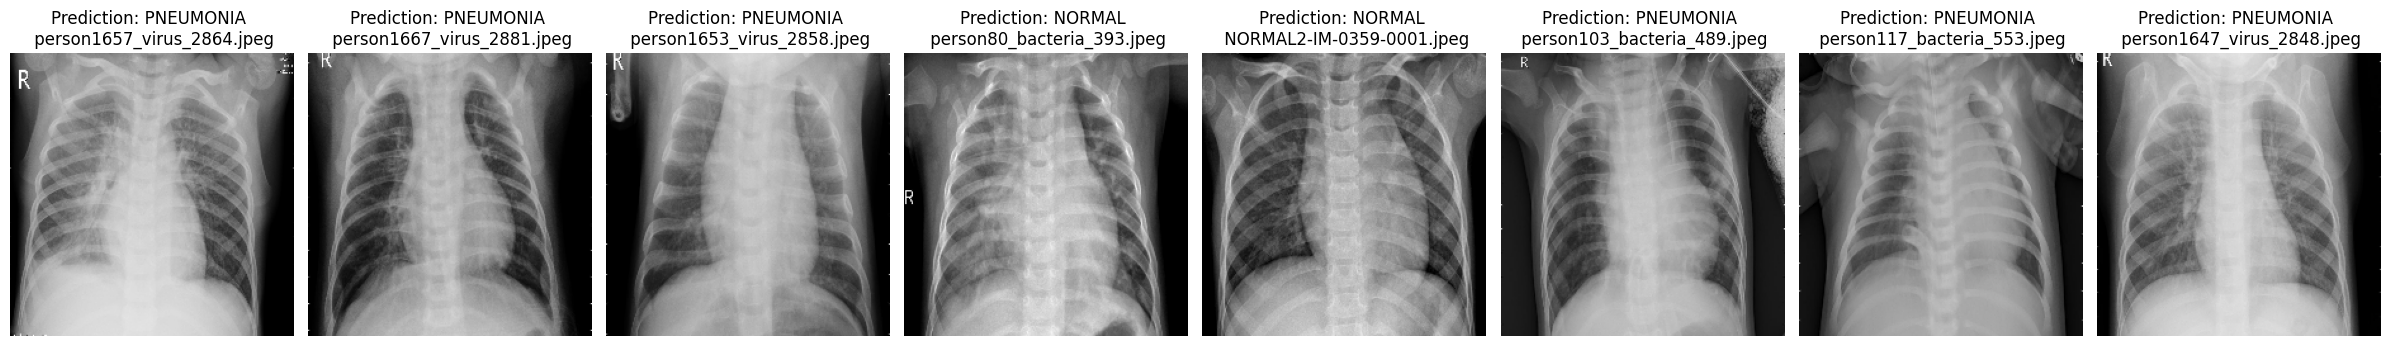

In [40]:
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Create a figure with N subplots
plt.figure(figsize=(3*N, 7))  # Adjust the figure size as needed

for i in range(N):
    # Display the original image
    plt.subplot(1, N, i+1)
    plt.imshow(cv2.cvtColor(list_imgs[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.axis('off')
    plt.title(f"Prediction: {pred_to_text(pred[i][0])} \n {os.path.basename(random_image_path[i])}")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

## With pre-trained model

### Import the model

In [41]:
import keras_hub

# Define a ResNet backbone (ResNet-50-like)
backbone = keras_hub.models.ResNetBackbone(
    image_shape=(width, height, 3),  # Explicit input shape
    input_conv_filters=[64],  # Number of filters in the initial convolution
    input_conv_kernel_sizes=[7],  # Kernel size of the initial convolution
    stackwise_num_filters=[64, 128, 256, 512],  # Number of filters in each stack
    stackwise_num_blocks=[3, 4, 6, 3],  # Number of blocks in each stack (ResNet-50-like)
    stackwise_num_strides=[1, 2, 2, 2],  # Strides for each stack
    block_type="bottleneck_block",  # Use bottleneck blocks for deeper networks
    name="res_net_backbone"
)

# Print the backbone summary
backbone.summary()

Model: "res_net_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack0_block0_1_conv      │ (None, 56, 56, 64)     │          4,096 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack0_block0_1_bn        │ (None, 56, 56, 64)     │            256 │ stack0_block0_1_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack0_block0_1_relu      │ (None, 56, 56, 64)     │              0 │ stack0_block0_1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack0_block0_2_conv      │ (None, 56, 56, 64)     │         36,864 │ stack0_block0_1_relu[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack0_block0_2_bn        │ (None, 56, 56, 64)     │            256 │ stack0_block0_2_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack0_block0_2_relu      │ (None, 56, 56, 64)     │              0 │ stack0_block0_2_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack0_block0_0_conv      │ (None, 56, 56, 256)    │         16,384 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack0_block0_3_conv      │ (None, 56, 56, 256)    │         16,384 │ stack0_block0_2_relu[… │
│ (Conv2D)             

 Total params: 23,561,152 (89.88 MB)

 Trainable params: 23,508,032 (89.68 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [42]:
from keras import layers, models, regularizers

# Add your own custom layers on top of the convolutional base
imported_image_classifier = models.Sequential([
    backbone,  # Convolutional base
    layers.GlobalAveragePooling2D(),  # Global average pooling

    # Dense layer with L2 regularization to avoid overfitting

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation='sigmoid', name='predictions')  # Output layer for binary classification
])

imported_image_classifier.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ res_net_backbone (ResNetBackbone)    │ (None, 7, 7, 2048)          │      23,561,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,085,953 (91.88 MB)

 Trainable params: 24,032,833 (91.68 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Training

In [43]:
imported_image_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy (name="acc"),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall"),
             keras.metrics.AUC(name="auc")]
)

best_imported_model_path = "best_imported_model.keras"

imported_image_classifier_callbacks = [
    keras.callbacks.ModelCheckpoint(best_imported_model_path, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
]

In [44]:
history_imported_image_classifier = imported_image_classifier.fit(
        train_dataset,
        epochs=epochs,
        callbacks=imported_image_classifier_callbacks,
        validation_data=val_dataset,
        class_weight=train_classes_weights,
        verbose=1
    )

Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 96s 596ms/step - acc: 0.7894 - auc: 0.8529 - loss: 4.1084 - precision: 0.9285 - recall: 0.7729 - val_acc: 0.2816 - val_auc: 0.5301 - val_loss: 8.8164 - val_precision: 0.7826 - val_recall: 0.0464
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - acc: 0.9182 - auc: 0.9712 - loss: 1.3363 - precision: 0.9766 - recall: 0.9128 - val_acc: 0.9167 - val_auc: 0.9693 - val_loss: 0.7946 - val_precision: 0.9662 - val_recall: 0.9201
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - acc: 0.9094 - auc: 0.9671 - loss: 0.7123 - precision: 0.9750 - recall: 0.9029 - val_acc: 0.7902 - val_auc: 0.9635 - val_loss: 0.8203 - val_precision: 0.9929 - val_recall: 0.7229
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - acc: 0.9365 - auc: 0.9842 - loss: 0.3817 - precision: 0.9856 - recall: 0.9274 - val_acc: 0.9435 - val_auc: 0.9879 - val_loss: 0.2860 - val_precision: 0.9314 - val_recall: 0.9974
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - acc: 0.9576 -

In [45]:
# Access history data
print(history_imported_image_classifier.history.keys())  # Shows available metrics like loss, accuracy, etc.
print(history_imported_image_classifier.history['loss'])  # Prints loss value per epoch
print(history_imported_image_classifier.history['acc'])  # Prints accuracy value per epoch
print(history_imported_image_classifier.history['precision'])  # Prints Precision value per epoch
print(history_imported_image_classifier.history['recall'])  # Prints Recall value per epoch
print(history_imported_image_classifier.history['auc'])  # Prints AUC value per epoch

dict_keys(['acc', 'auc', 'loss', 'precision', 'recall', 'val_acc', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])
[3.008146047592163, 1.116502285003662, 0.6074283719062805, 0.33673176169395447, 0.20801274478435516, 0.1573953777551651, 0.11427133530378342, 0.09630638360977173, 0.0838334932923317, 0.11382463574409485]
[0.8492329716682434, 0.9268935918807983, 0.9223393797874451, 0.9417545795440674, 0.9527804255485535, 0.9587727785110474, 0.9647650718688965, 0.9729146957397461, 0.9717162251472473, 0.9604506492614746]
[0.9567307829856873, 0.9790809154510498, 0.9759863018989563, 0.9850543737411499, 0.9856091141700745, 0.9870216250419617, 0.9903654456138611, 0.9907955527305603, 0.9917519092559814, 0.9906354546546936]
[0.8347854018211365, 0.9212649464607239, 0.9180380702018738, 0.935785710811615, 0.9503065347671509, 0.9570829272270203, 0.9619231820106506, 0.9725717902183533, 0.9699903130531311, 0.9557921886444092]
[0.91631019115448, 0.9763793349266052, 0.9736899137496948, 0.98532503843

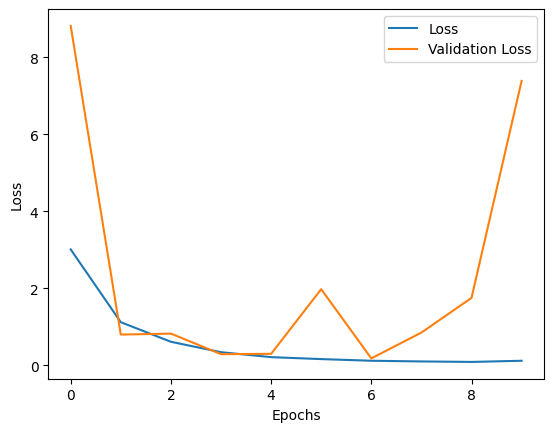

In [46]:
# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history_imported_image_classifier.history['loss'], label='Loss')
plt.plot(history_imported_image_classifier.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

In [47]:
score_imported_model = imported_image_classifier.evaluate(test_dataset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 676ms/step - acc: 0.4250 - auc: 0.6314 - loss: 5.0959 - precision: 0.9770 - recall: 0.1054


In [48]:
# Print the evaluation results
print(f"Test Loss: {score_imported_model[0]}")
print(f"Test Accuracy: {score_imported_model[1]}")
print(f"Test Precision: {score_imported_model[2]}")
print(f"Test Recall: {score_imported_model[2]}")

f1_score_imported_model = 2 * (score_imported_model[2] * score_imported_model[3]) / (score_imported_model[2] + score_imported_model[3])
print(f"Test F1 Score: {f1_score_imported_model}")

Test Loss: 5.18953275680542
Test Accuracy: 0.42628204822540283
Test Precision: 0.9444444179534912
Test Recall: 0.9444444179534912
Test F1 Score: 0.15962441654591727


Verify with prediction

In [49]:
# Use generators for large datasets
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),  # This will resize all images to 224x224
    batch_size=8,
    class_mode='binary'  # or 'binary' depending on your problem
    )

Found 624 images belonging to 2 classes.


In [50]:
# Get the results of the prediction on the picture
pred = imported_image_classifier.predict(generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step


In [51]:
# Get the number of elements per classes predicted
predicted_classes, counts = np.unique(np.argmax(pred, axis=1), return_counts=True)
# Create dictionary using zip()
result_dict = dict(zip(predicted_classes.tolist(), counts.tolist()))

print(f"Prediction classes: {result_dict}")

Prediction classes: {0: 624}


### Application

In [52]:
# Number of images to display
N = 8

# Select randomly pictures
random_image_path = select_random_images_from_folder(test_path, N) # Get the first and only element from the list

# Load the image and resize it from it's path
def load_and_resize_image(image_path, target_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    return img

list_imgs = [load_and_resize_image(path, target_size) for path in random_image_path]

# Expands the dimensions to fit it to the input shape of the model
X = tf.convert_to_tensor(list_imgs)

Number of images in folder : 624
Indices selected : [592  94 528 245 243  85 227 502]


In [53]:
input_shape = imported_image_classifier.layers[0].input_shape
print(f"Model expects input shape: {input_shape}")

Model expects input shape: (None, 224, 224, 3)


In [64]:
from tensorflow.keras.models import Model

def create_gradcam_model(classifier_model):
    """Always-use-this version that reliably works"""
    input_tensor = keras.Input(shape=classifier_model.input_shape[1:])

    # Recreate forward pass
    x = input_tensor
    backbone_output = None
    predictions_output = None

    for layer in classifier_model.layers:
        x = layer(x)
        if layer.name == "res_net_backbone":
            backbone_output = x
        if layer.name == "predictions":
            predictions_output = x

    if backbone_output is None or predictions_output is None:
        raise ValueError("Could not find required layers in model")

    return keras.models.Model(
        inputs=input_tensor,
        outputs=[backbone_output, predictions_output]
    )
grad_model = create_gradcam_model(imported_image_classifier)
grad_model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_backbone (ResNetBackbone)    │ (None, 7, 7, 2048)          │      23,561,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,085,953 (91.88 MB)

 Trainable params: 24,032,833 (91.68 MB)

 Non-trainable params: 53,120 (207.50 KB)

We're going to use the last pooling layer to display the heatmap over the image.

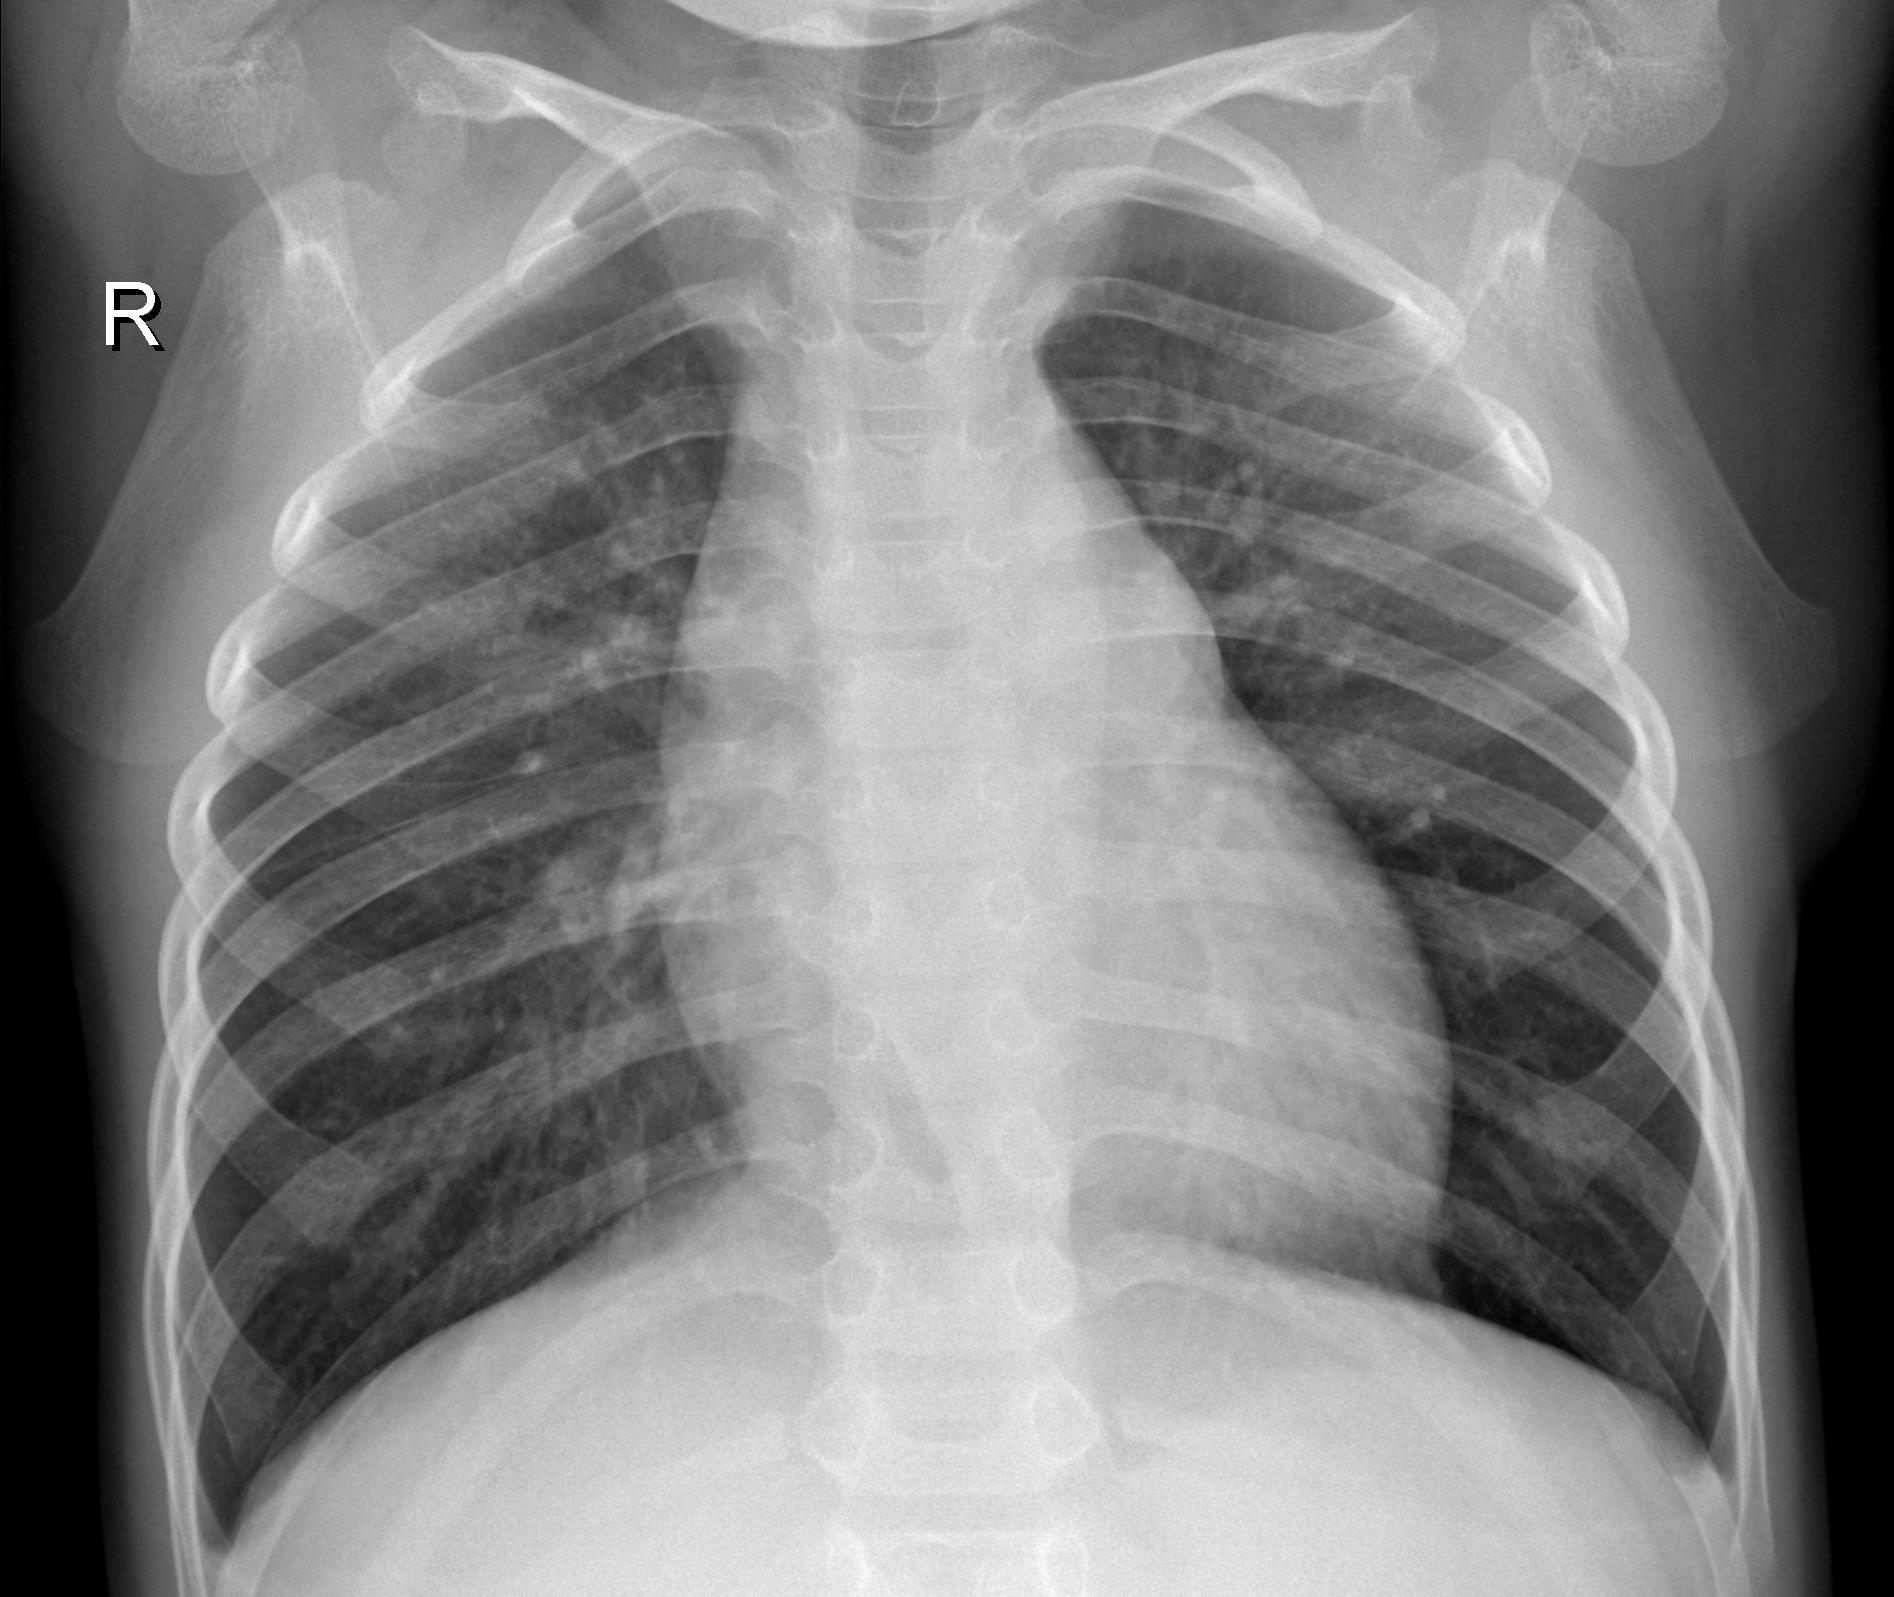

In [65]:
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

img_size = target_size

## The local path to our target image
img_path = random_image_path[0]

display(Image(img_path, width=width, height=height))

def get_img_array(img_path, size):
    ## `img` is a PIL image
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    ## We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, grad_model, pred_index=None):
    ## We compute the gradient of the predicted class for our input image
    ## for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        # For binary classification, we directly use the single output
        class_channel = preds[:, 0] # Only one output neuron for binary classification

    ## We are doing transfer learning on last layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    ## This is a vector where each entry is the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    ## Calculate heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## For visualization purpose
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

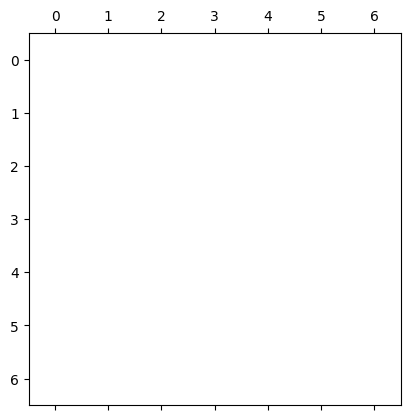

In [66]:
from keras.applications.resnet50 import preprocess_input

## Preparing the image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

## Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, grad_model)

## visulization of heatmap
plt.matshow(heatmap)
plt.show()

In [67]:
# Test the original model
test_pred = imported_image_classifier.predict(img_array)
print("Model prediction shape:", test_pred.shape)
print("Prediction value:", test_pred[0][0])

# Test your grad_model
conv_output, pred_output = grad_model.predict(img_array)
print("Conv output shape:", conv_output.shape)
print("Pred output shape:", pred_output.shape)
print("Pred output value:", pred_output[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Model prediction shape: (1, 1)
Prediction value: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Conv output shape: (1, 7, 7, 2048)
Pred output shape: (1, 1)
Pred output value: 1.0
